# Kansas CAI ~~Snark~~ Review

My friend from the internet asked me to look at a list of CAI's... I can't imagine what is about to go wrong.

In [23]:
import pathlib, itables, pygris, numpy, folium, matplotlib, mapclassify, requests, json, zipfile, io
import pandas as pd
import geopandas as gpd
from pprint import pprint

itables.options.style = 'float:left;width:auto'

## Let's take a look

Time to crack open the list.

In [2]:
cai = pd.read_csv(pathlib.Path('data', 'cai.csv'))

In [3]:
itables.show(cai)

Lame! Let's just drop it in a map really quick: [here](https://felt.com/map/Kansas-CAI-Kpe4ZgiMSJm4IDOKFHlADD?loc=38.514,-98.322,7.93z&share=1) HT: Felt.com

Let's start to dig into the actual data. It's GEO TIME!!!

In [8]:
cai = gpd.GeoDataFrame(cai, geometry=gpd.points_from_xy(cai.Longitude, cai.Latitude), crs='EPSG:4326')

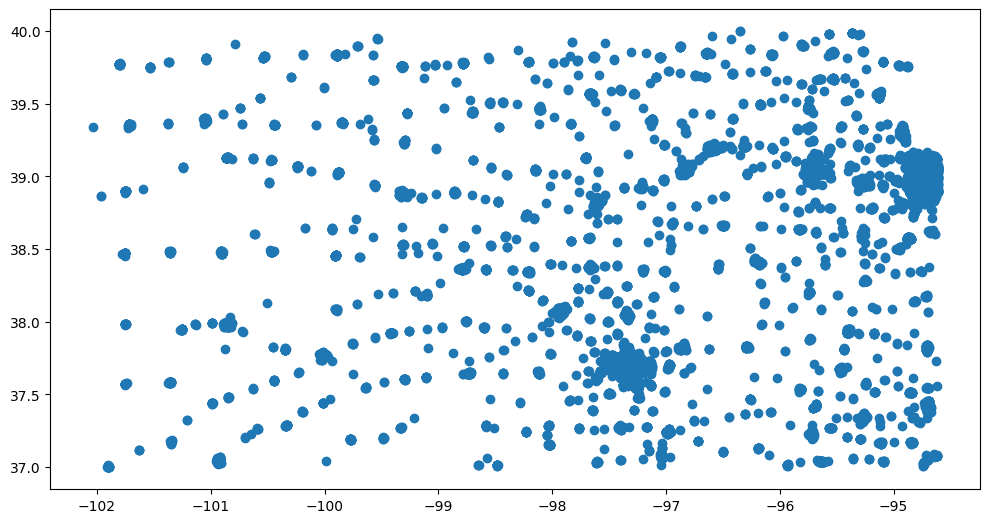

In [11]:
ax = cai.plot(figsize=(12, 12))

That's ugly... let's add color.

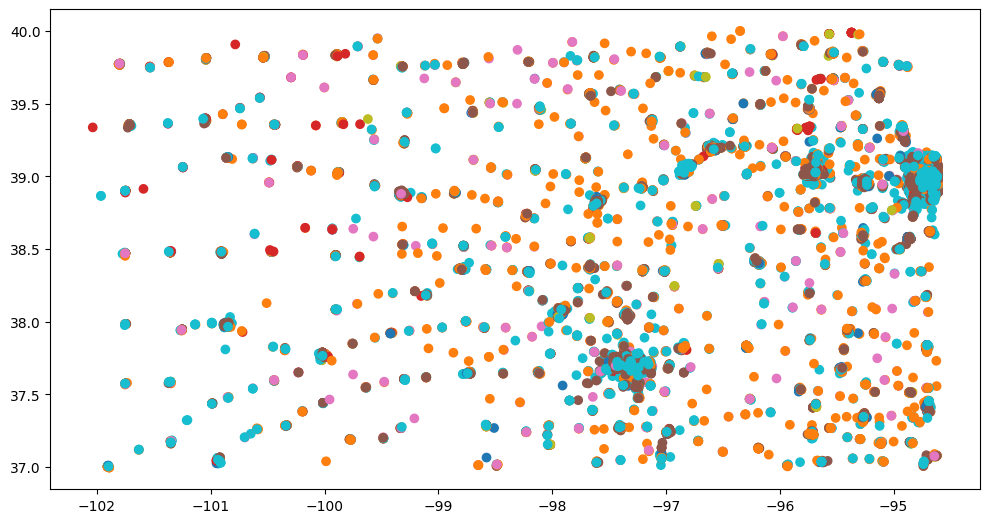

In [14]:
ax = cai.plot(column='CAI Type', figsize=(12,12))

Yeah that doesnt say much. Lets see if we can do an H3 Analysis!

## The H3 Part

In [18]:
s = requests.Session()
s.headers.update({'User-Agent': 'j23servedAnalysis/0.0.1'})
url = 'https://broadbandmap.fcc.gov/nbm/map/api/published/filing'
response = s.get(url, timeout=5)
response
parsed = json.loads(response.text)
uuid = parsed['data'][2]['process_uuid']
pprint(parsed['data'][2])
pprint(uuid)
url = f"https://broadbandmap.fcc.gov/nbm/map/api/national_map_process/nbm_get_data_download/{uuid}/"
response = s.get(url, timeout=5)
parsed = json.loads(response.text)
filingData = pd.DataFrame(parsed['data'])
subsetAvalibility = filingData[(filingData.state_name == 'Kansas') & (filingData.file_type == 'csv')].reset_index()

{'enable_bfm_link': True,
 'enable_challenge_download': True,
 'filing_subtype': 'June 30, 2023',
 'filing_type': 'Biannual',
 'filing_type_id': 100007,
 'process_uuid': 'bd021722-8a6b-4709-8bcc-5a11859f69cf'}
'bd021722-8a6b-4709-8bcc-5a11859f69cf'


In [19]:
itables.show(subsetAvalibility)

In [27]:
baseUrl = ("https://broadbandmap.fcc.gov/nbm/map/api/getNBMDataDownloadFile/", "/1")

availabilityDf = pd.DataFrame()

for item in subsetAvalibility.to_dict('records'):
    # pprint(item)
    print(item['file_name'])
    # print(url)
    file = pathlib.Path('data', 'fcc-avail', f'{item['file_name']}.zip')
    if file.exists():
        with open(file, 'rb') as f:
            data = f.read()
    else:
        if pathlib.Path(file).parent.exists() == False:
            pathlib.Path(file.parent).mkdir()
        url = f'{baseUrl[0]}{item['id']}{baseUrl[1]}'
        r = s.get(url)
        with open(file, 'wb') as f:
            f.write(r.content)
        data = r.content
    zip = zipfile.ZipFile(io.BytesIO(data))
    df = pd.read_csv(zip.open(zip.filelist[0].filename))
    availabilityDf = pd.concat([availabilityDf, df], ignore_index=True)

bdc_20_Other_fixed_broadband_J23_12dec2023
bdc_20_Copper_fixed_broadband_J23_12dec2023
bdc_20_Cable_fixed_broadband_J23_12dec2023
bdc_20_FibertothePremises_fixed_broadband_J23_12dec2023
bdc_20_GSOSatellite_fixed_broadband_J23_12dec2023
bdc_20_NGSOSatellite_fixed_broadband_J23_12dec2023
bdc_20_UnlicensedFixedWireless_fixed_broadband_J23_12dec2023
bdc_20_LicensedFixedWireless_fixed_broadband_J23_12dec2023
bdc_20_LBRFixedWireless_fixed_broadband_J23_12dec2023


In [29]:
itables.show(availabilityDf)